In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import tqdm

data_path = "./data/"

In [2]:
table = cv.imread(data_path + "src_balls.jpg")

### Original image

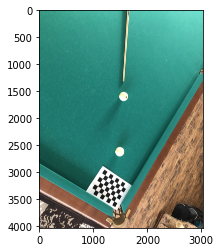

In [132]:
plt.imshow(cv.cvtColor(table, cv.COLOR_BGR2RGB))

In [134]:
ret, corners = cv.findChessboardCorners(cv.cvtColor(table, cv.COLOR_BGR2GRAY), (7, 5), None)
ret

True

In [135]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
fine_corners = cv.cornerSubPix(cv.cvtColor(table, cv.COLOR_BGR2GRAY), corners, (11,11), (-1,-1), criteria)

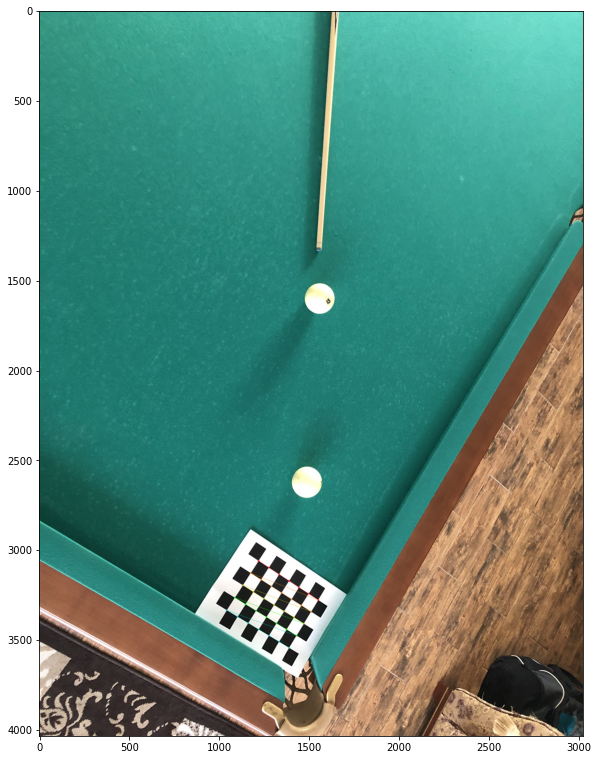

In [137]:
table_w_corners = table.copy()
cv.drawChessboardCorners(table_w_corners, (7,5), fine_corners, ret)
scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * table_w_corners.shape[0] / table_w_corners.shape[1]))
plt.imshow(cv.cvtColor(table_w_corners, cv.COLOR_BGR2RGB))

In [138]:
objpoints = np.zeros((1, 7*5,3), np.float32)
objpoints[0, :,:2] = np.mgrid[0:7,0:5].T.reshape(-1,2)
objpoints.shape

(1, 35, 3)

In [139]:
imgpoints = fine_corners
imgpoints.shape

(35, 1, 2)

In [140]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, [imgpoints], cv.cvtColor(table_w_corners, cv.COLOR_BGR2GRAY).shape[::-1], None, None)

In [141]:
h,  w = table.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

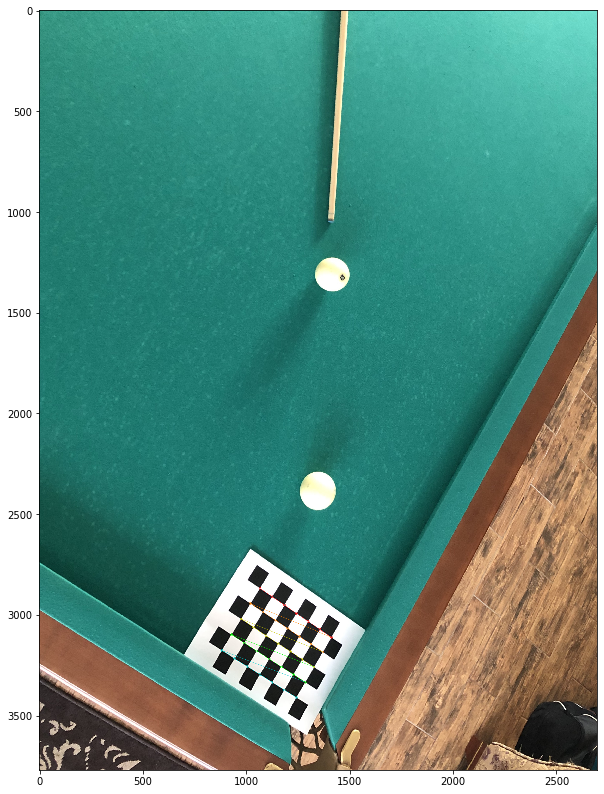

In [130]:
undist_table = cv.undistort(table_w_corners, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
undist_table = undist_table[y:y+h, x:x+w]
scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * undist_table.shape[0] / undist_table.shape[1]))
plt.imshow(cv.cvtColor(undist_table, cv.COLOR_BGR2RGB), interpolation='nearest', aspect='auto')

In [86]:
roi

(155, 103, 2699, 3770)